# Validation Techniques

## Overview

https://scikit-learn.org/stable/modules/cross_validation.html

* Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. 
* This situation is called **overfitting.** 
* To avoid it, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set `X_test, y_test`

## Train-Test-Split

* In scikit-learn a random split into training and test sets can be quickly computed with the train_test_split helper function.

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

In [0]:
iris = datasets.load_iris()
X = iris.data
Y = iris.target

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, stratify = None, random_state = 31, test_size = 0.4)

In [0]:
clf = svm.SVC(kernel = 'rbf', C = 0.9)
clf.fit(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=0.9, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
clf.score(X_test, Y_test)

0.9833333333333333

* When evaluating different settings (“hyperparameters”) for estimators, such as the C setting that must be manually set for an SVM, there is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. 

* This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. 

* To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.

* However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

## Cross-validation

* A solution to this problem is a procedure called cross-validation (CV for short).
* A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). 

* The following procedure is followed for each of the k “folds”:

* A model is trained using $ k - 1 $
of the folds as training data.
* The resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy)

* The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. 

* This approach can be computationally expensive, but does not waste too much data (as is the case when fixing an arbitrary validation set), which is a major advantage in problems such as inverse inference where the number of samples is very small.

## Cross_val_score

In [0]:
from sklearn.model_selection import cross_val_score

In [0]:
clf = svm.SVC(kernel = 'linear', C = 1)
scores = cross_val_score(clf, iris.data, iris.target)
print(scores)

[1.         0.96078431 0.97916667]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [0]:
print("Accuracy: %0.2f (+/- %0.2f)" %(scores.mean(), scores.std()*2))

Accuracy: 0.98 (+/- 0.03)


In [0]:
from sklearn import metrics
scores = cross_val_score(clf, iris.data, iris.target, cv=5, scoring = 'f1_micro')

In [0]:
print(scores)

[0.96666667 1.         0.96666667 0.96666667 1.        ]


* When the cv argument is an integer, cross_val_score uses the KFold or StratifiedKFold strategies by default, the latter being used if the estimator derives from ClassifierMixin.

* It is also possible to use other cross validation strategies by passing a cross validation iterator instead, for instance:

In [0]:
from sklearn.model_selection import ShuffleSplit
n_samples = iris.data.shape[0]
cv = ShuffleSplit(n_splits = 5, test_size = 0.3, random_state = 31)
cross_val_score(clf, iris.data, iris.target, cv = cv)

array([0.95555556, 0.97777778, 1.        , 1.        , 1.        ])

## Cross-validate function

The cross_validate function differs from cross_val_score in two ways:

* It allows specifying multiple metrics for evaluation.
* It returns a dict containing fit-times, score-times (and optionally training scores as well as fitted estimators) in addition to the test score.


In [0]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score

In [0]:
scoring = ['precision_macro', 'recall_macro']
clf = svm.SVC(C=1, kernel = 'rbf', random_state=31)
scores = cross_validate(clf, iris.data, iris.target, cv = 5, scoring = scoring)

In [0]:
print(sorted(scores.keys()))

['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']


In [0]:
scores['test_recall_macro']

array([0.96666667, 1.        , 0.96666667, 0.96666667, 1.        ])

## Cross-validation iterators

* Assuming that some data is Independent and Identically Distributed (i.i.d.) is making the assumption that all samples stem from the same generative process and that the generative process is assumed to have no memory of past generated samples.

* While i.i.d. data is a common assumption in machine learning theory, it rarely holds in practice. If one knows that the samples have been generated using a time-dependent process, it’s safer to use a time-series aware cross-validation scheme Similarly if we know that the generative process has a group structure (samples from collected from different subjects, experiments, measurement devices) it safer to use group-wise cross-validation.

### K-Fold

* K-fold divides the samples in k-groups of samples called folds of equal sizes.
* The prediction is learned using $ k - 1 $ folds, and fold left out is used to test.

In [0]:
import numpy as np
from sklearn.model_selection import KFold

In [0]:
X = ["a","b","c","d"]
kf = KFold(n_splits = 2)

In [0]:
for train, test in kf.split(X):
    print("%s %s" %(train, test))

[2 3] [0 1]
[0 1] [2 3]


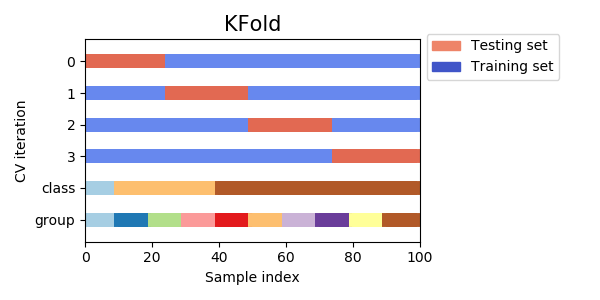

### Repeated K-Fold

* This repeats K-Fold n times. It can be used when one requires to run `KFold` n times.

In [0]:
import numpy as np
from sklearn.model_selection import RepeatedKFold

In [0]:
X = np.array([[1,2], [3, 4], [1, 2], [3, 4]])
rkf = RepeatedKFold(n_splits = 2, n_repeats=2, random_state = 31)
for train, test in (rkf.split(X)):
    print("%s %s" %(train, test))

[0 2] [1 3]
[1 3] [0 2]
[2 3] [0 1]
[0 1] [2 3]


### Leave One Out

* LeaveOneOut (or LOO) is a simple cross-validation. Each learning set is created by taking all the samples except one, the test set being the sample left out. 

* Thus, for $n$ samples, we have different training sets and different tests set. This cross-validation procedure does not waste much data as only one sample is removed from the training set:

In [0]:
from sklearn.model_selection import LeaveOneOut

In [0]:
X = [1,2,3,4]
loo = LeaveOneOut()

In [0]:
for train, test in loo.split(X):
    print("%s %s" %(train, test))
    

[1 2 3] [0]
[0 2 3] [1]
[0 1 3] [2]
[0 1 2] [3]


* However, if the learning curve is steep for the training size in question, then 5- or 10- fold cross validation can overestimate the generalization error.

* As a general rule, most authors, and empirical evidence, suggest that 5- or 10- fold cross validation should be preferred to LOO.

### Leave P Out

* LeavePOut is very similar to LeaveOneOut as it creates all the possible training/test sets by removing $p$ samples from the complete set. 

* For samples, this produces $ n \choose p $ train-test pairs. Unlike LeaveOneOut and KFold

In [0]:
from sklearn.model_selection import LeavePOut
import numpy as np

In [0]:
X = np.ones(4)
lpo = LeavePOut(p = 2)
for train, test in lpo.split(X):
    print("%s %s" % (train, test))

[2 3] [0 1]
[1 3] [0 2]
[1 2] [0 3]
[0 3] [1 2]
[0 2] [1 3]
[0 1] [2 3]


### ShuffleSplit

* The ShuffleSplit iterator will generate a user defined number of independent train / test dataset splits. Samples are first shuffled and then split into a pair of train and test sets.

* It is possible to control the randomness for reproducibility of the results by explicitly seeding the random_state pseudo random number generator.

* Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [0]:
from sklearn.model_selection import ShuffleSplit

In [0]:
X = np.arange(10)
ss = ShuffleSplit(n_splits = 5, test_size = 0.25, random_state = 31)

In [0]:
for train,test in ss.split(X):
    print("%s %s" %(train, test))

[8 5 9 6 0 7 2] [4 1 3]
[3 5 1 7 2 9 6] [8 4 0]
[6 5 3 8 2 4 1] [9 0 7]
[0 3 2 1 9 8 7] [6 5 4]
[2 5 6 7 8 9 1] [4 3 0]


* ShuffleSplit is thus a good alternative to KFold cross validation that allows a finer control on the number of iterations and the proportion of samples on each side of the train / test split.

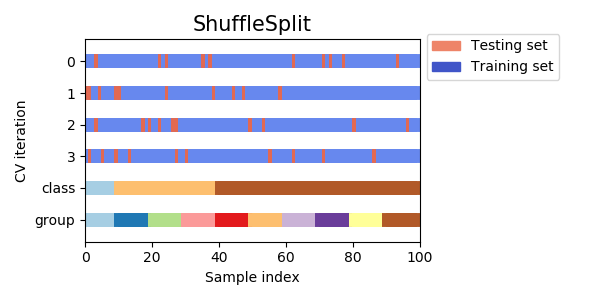

## Cross-validation with stratification on Class Labels

* Some classification problems can exhibit a large imbalance in the distribution of the target classes: for instance there could be several times more negative samples than positive samples. 

* In such cases it is recommended to use stratified sampling as implemented in `StratifiedKFold` and `StratifiedShuffleSplit` to ensure that relative class frequencies is approximately preserved in each train and validation fold.

### Stratified K-Fold

* `StratifiedKFold` is a variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set.

* Example of stratified 3-fold cross-validation on a dataset with 10 samples from three slightly unbalanced classes:

In [0]:
from sklearn.model_selection import StratifiedKFold

In [0]:
X = np.ones(10)
y = [0,0,0,0,1,1,1,2,2,2]
skf = StratifiedKFold(n_splits = 3, shuffle = False, random_state=1)

In [0]:
for train, test in skf.split(X,y):
    print("%s %s" %(train, test))

[2 3 5 6 8 9] [0 1 4 7]
[0 1 3 4 6 7 9] [2 5 8]
[0 1 2 4 5 7 8] [3 6 9]


* `RepeatedStratifiedKFold` can be used to repeat Stratified K-Fold n times with different randomization in each repetition.

### Stratified Shuffle Split

* `StratifiedShuffleSplit` is a variation of ShuffleSplit, which returns stratified splits, i.e which creates splits by preserving the same percentage for each target class as in the complete set.

* Here is a visualization of the cross-validation behavior.

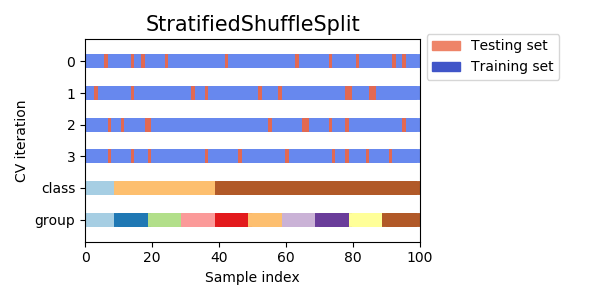

## Cross-validation For Grouped Data

## Cross Validating Time-Series Data

* Times Series data is characterised by the correlation between observation that are near in time (autocorrelation).
* However, classical cross-validation techniques such as `KFold` and `ShuffleSpilt` assume that samples are indenpendent and identically distributed.
* It would result in unreasonable correlation between training and testing instances (yielding poor estimates of generalisation error) on time series data
* Therefore, it is very important to evaluate our model for time series data on the “future” observations least like those that are used to train the model. To achieve this, one solution is provided by `TimeSeriesSplit`.

### Time-Series-Split

* TimeSeriesSplit is a variation of k-fold which returns first $k$ folds as train set and the next $ (k + 1) $ th fold as test set. 

* Note that unlike standard cross-validation methods, successive training sets are supersets of those that come before them. 

* Also, it adds all surplus data to the first training partition, which is always used to train the model.

* This class can be used to cross-validate time series data samples that are observed at fixed time intervals.

- Example of 3-split time series cross-validation on a dataset with 6 samples:

In [0]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import matplotlib.pyplot as plt

In [0]:
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1,2,3,4,5,6])

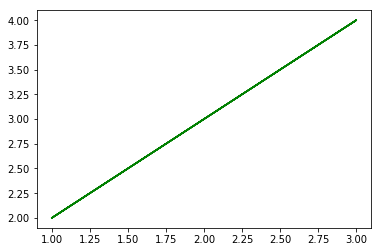

In [0]:
plt.plot(X[:,0], X[:,1], c  = 'g')
plt.show()

In [0]:
tscv = TimeSeriesSplit(n_splits = 3)

In [0]:
for train, test in tscv.split(X):
    print("%s %s" % (train, test))

[0 1 2] [3]
[0 1 2 3] [4]
[0 1 2 3 4] [5]


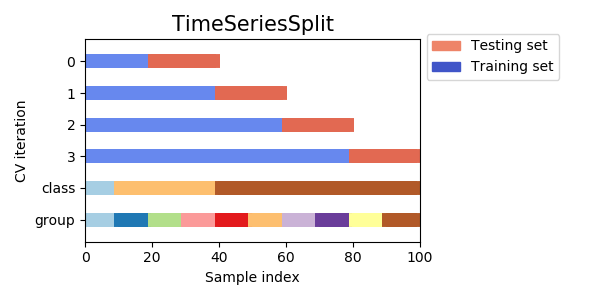

## Notes

* If the data ordering is not arbitrary (e.g. samples with the same class label are contiguous), shuffling it first may be essential to get a meaningful cross- validation result. 

* However, the opposite may be true if the samples are not independently and identically distributed. 

* For example, if samples correspond to news articles, and are ordered by their time of publication, then shuffling the data will likely lead to a model that is overfit and an inflated validation score: it will be tested on samples that are artificially similar (close in time) to training samples.

* Some cross validation iterators, such as KFold, have an inbuilt option to shuffle the data indices before splitting them. 

Note that:

* This consumes less memory than shuffling the data directly.
By default no shuffling occurs, including for the (stratified) K fold cross- validation performed by specifying cv=some_integer to cross_val_score, grid search, etc. 

* Keep in mind that train_test_split still returns a random split.

* The random_state parameter defaults to None, meaning that the shuffling will be different every time KFold(..., shuffle=True) is iterated. However, GridSearchCV will use the same shuffling for each set of parameters validated by a single call to its fit method.

* To get identical results for each split, set random_state to an integer.
